## Holland synthetic figure 

In [1]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from scipy.signal import argrelextrema
from datetime import datetime

# Custom
# import functions as f

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [8]:
PRMS = {
    'save_figs':       False,
    'n':               5,  # R+ is defined as omega(R+) = n * f
    'k':               3, # nb of reps
    'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
}

### OPEN DATA
dsg = xr.open_dataset(PRMS['ds_glob_path'])
print('Nb of storms: {}'.format(len(dsg.time)))

### Add intensification parameters
dsg2 = xr.open_dataset('/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_17102022_with_extra_params.nc')
dsg['Vmax_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_smth_IBT']),
    coords={'time': dsg.time}
)
dsg['Vmax_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_smth_IBT']),
    coords={'time': dsg.time}
)

### Kinetic energy
K1_SAR = dsg['Vmax_1D'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R17_1D'] * 1000) ** 2)
K2_SAR = dsg['R17_1D'] * 1000 * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_1D'] ** 2)
K1_IBT = dsg['Vmax_IBT'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R34_IBT']) ** 2) 
K2_IBT = dsg['R34_IBT'] * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_IBT'] ** 2)

dsg['dKdt_SAR'] = K1_SAR + K2_SAR
dsg['dKdt_IBT'] = K1_IBT + K2_IBT

Nb of storms: 335


In [3]:
### FILTER
dsg = dsg.where(dsg.distance_to_coast > dsg.R17_1D * 1000, drop=True)
dsg = dsg.where(abs(dsg.lat_center) < 30, drop=True)
# dsg = dsg.where(dsg.lon_center < -50, drop=True) # Keep only USA best-track agencies
# dsg = dsg.where(dsg.distance_to_coast > 200000, drop=True)
print('Nb of storms: {}'.format(len(dsg.time)))

Nb of storms: 195


In [4]:
### FUNCTIONS
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15

    r      = r.astype(np.float) + 0.001 # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

rs = np.linspace(0, 500000, 50001) # define dr accordingly
def vorticity(r, v):
    '''Relative vorticity'''
    dr = 10 # meters
    return (1 / r) * np.gradient(r * v, dr)

In [5]:
# Initialize
lats  = np.linspace(10, 30,  PRMS['k'])
Bs    = np.linspace(1, 2.5,  PRMS['k'])
Vmins = np.linspace(2.5, 15, PRMS['k'])
Rmaxs = np.linspace(5 * 1000, 50 * 1000,  PRMS['k'])
Vmaxs = np.linspace(20, 70,  PRMS['k'])

In [6]:
listOfDatasets = []
rf             = np.linspace(0.05, 5, 10000)

for l in tqdm(lats):
    for B in Bs:
        for vmn in Vmins:
            for rmx in Rmaxs:
                for vmx in Vmaxs:
                    # print('Lat = {:.1f}, B = {:.1f}, Vmin = {:.1f}, Rmax = {:.1f}, Vmax = {:.1f}'.format(l, B, vmn, rmx, vmx))
                    Vh = holland_profile(rs, l, B, vmn, rmx, vmx)
                    # plt.plot(rs, Vh, c='tab:gray', alpha=0.5)
                    
                    # Compute R+
                    out      = rs > rmx                # To find outer-core
                    r        = rs[out]
                    vrt      = vorticity(rs, Vh)[out]  # Relative vorticity
                    vrt_plan = coriolis(l)             # Planetary vorticity                    
                    try: # For Vmax = 20 m/s, sometimes 5 * f is not achieved. In this case R_plus is set to NaN
                        R_plus = r[abs(vrt - PRMS['n'] * vrt_plan) < 1e-7][0] 
                        V_plus = Vh[out][abs(vrt - PRMS['n'] * vrt_plan) < 1e-7][0] # note sure
                    except IndexError:
                        R_plus = V_plus = np.nan
                        
                    # Compute rv^2 / R+V+^2
                    rv2 = rs * (Vh ** 2) / (R_plus * (V_plus ** 2))
                    if ~np.isnan(R_plus):
                        dsr = xr.Dataset(
                            data_vars={
                                'rv2':  ('r_star', np.array(rv2)),
                                'B':    float(B),
                                'Rmax': float(rmx),
                                'Vmax': float(vmx),
                            },
                            coords={'r_star': np.array(rs / R_plus)}
                        )
                        listOfDatasets.append(dsr.interp(coords={'r_star': rf}))
                        
print('Concatenating...')
dss = xr.concat(listOfDatasets, dim='i')
print('Concatenation ended.')

100%|█████████████████████████████████████████████| 4/4 [00:05<00:00,  1.30s/it]


Concatenating...
Concatenation ended.


100%|████████████████████████████████████████| 939/939 [00:02<00:00, 443.01it/s]


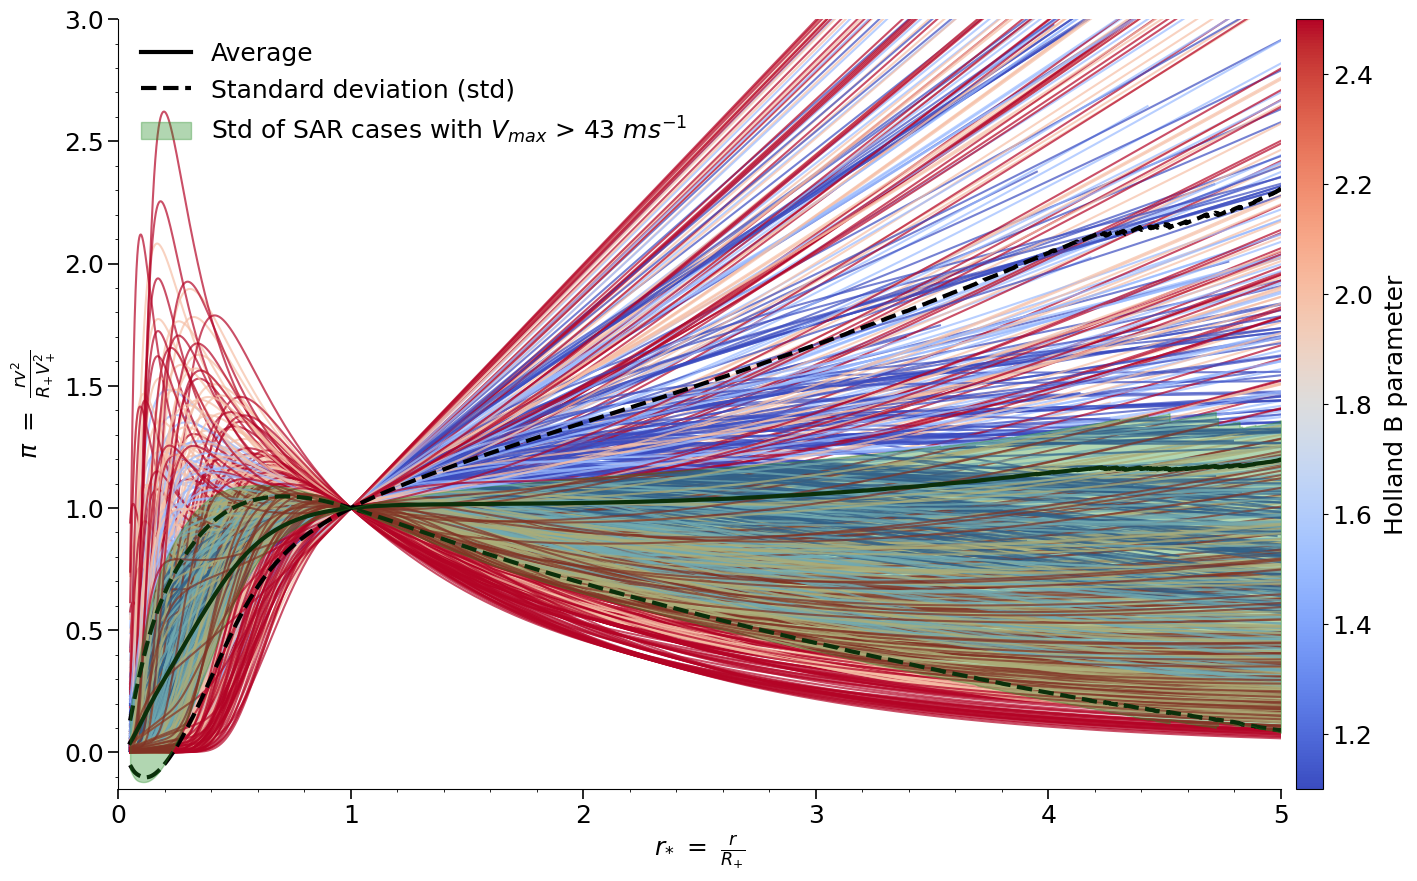

In [7]:
fig, ax     = plt.subplots(figsize=(15, 10))

c_min = 1.1
c_max = 2.5

dss['B_color'] = (dss.B - c_min) / (c_max - c_min)
cmap           = cm.get_cmap('coolwarm')

rv2m = dss.mean(dim='i').rv2
rv2s = dss.std(dim='i').rv2

# Iterate
for i in tqdm(np.arange(len(dss.i))):
    dss.isel(i=i).rv2.plot(color=cmap(dss.isel(i=i).B_color), alpha=0.7)

# # Wind radii
# ax.axvline((DSs.Rmax_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), ymin=0, ymax=float(rv2m.sel(r_star=(DSs.Rmax_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True), method='nearest')) / 2.7, linewidth=1.5, c='k', alpha=0.8)
# trans = ax.get_xaxis_transform()
# ax.text((DSs.Rmax_1D.mean(skipna=True) * 1000) / DSs.R_plus.mean(skipna=True) - 0.12, .015, r'$R_{max}$$_{*}$', c='k', alpha=0.8, transform=trans, rotation='vertical')
# # R0
# R0 = np.sqrt(2 * DSs.Rmax_1D * 1000 * DSs.Vmax_1D / (abs(coriolis(DSs.lat_center)))).mean(skipna=True)
# ax.axvline(R0 / DSs.R_plus.mean(skipna=True), ymin=0, ymax=0.34, linewidth=1.5, c='k', alpha=0.8)
# ax.text(R0 / DSs.R_plus.mean(skipna=True) - 0.12, .015, r'$R_{0}$$_{*}$', c='k', alpha=0.8, transform=trans, rotation='vertical')

# Mean and std
rv2m.plot(c='k', linewidth=3, label='Average'.format(len(dss.i)))
ax.plot(dss.r_star, rv2m + rv2s, c='k', linestyle='dashed', linewidth=3, label='Standard deviation (std)')
ax.plot(dss.r_star, rv2m - rv2s, c='k', linestyle='dashed', linewidth=3)
# Stronger than thrsh m/s
thrsh    = 43
d_hgh    = dss.where(dss.Vmax > thrsh, drop=True)
rv2m_hgh = d_hgh.mean(dim='i').rv2
rv2s_hgh = d_hgh.std(dim='i').rv2
ax.fill_between(dss.r_star, rv2m_hgh - rv2s_hgh, rv2m_hgh + rv2s_hgh, color='forestgreen', label=r'Std of SAR cases with $V_{max}$ > ' + '{}'.format(str(thrsh)) + r' $m s^{-1}$', zorder=2, alpha=0.35)

# Grid, legend
# ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylim(-0.15, 3)
ax.set_xlim(0, 5)
ax.set_ylabel(r'$\pi$ $=$ $\frac{rv^2}{R_{+} V_{+}^2}$')
ax.set_xlabel(r'$r_{*}$ $=$ $\frac{r}{R_{+}}$')
ax.legend(loc='upper left', frameon=False)

# Colorbar
norm = mpl.colors.Normalize(vmin=c_min, vmax=c_max)
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cb_ax = fig.add_axes([0.91, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax)
cbar.set_label('Holland B parameter', rotation=90)
cbar.ax.get_yaxis().labelpad=8

if PRMS['save_figs']:
    plt.savefig(PTHS['save_dir'] + 'rv2_charac.pdf', bbox_inches='tight', format='pdf')